In [ ]:
'''
Spaceship Titanic
Predict whether passenger was transported to alternate dimension or not
'''

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm
from scipy import stats

In [2]:
training_data=pd.read_csv('train.csv')
training_data.info()
training_data.head(10)
#training_data['VIP'].value_counts()
#training_data.index.is_unique

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


Text(0.5, 1.0, 'Total Missing Values')

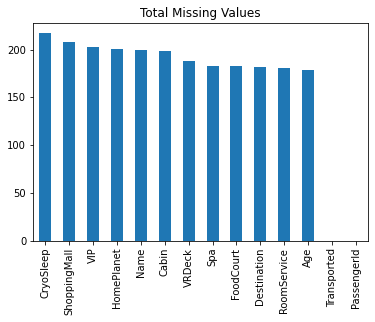

In [3]:
#find null values
total_null=training_data.isnull().sum().sort_values(ascending=False)
total_null.plot(kind='bar')
plt.title("Total Missing Values")

In [4]:
#fill null values
age_median=training_data['Age'].median()
training_data['Age'].fillna(age_median,inplace=True)

fill_with_most_frequent=['CryoSleep','ShoppingMall','VIP','HomePlanet','VRDeck','Spa','FoodCourt','Destination','RoomService']
for category in fill_with_most_frequent:
    training_data[category].fillna(training_data[category].mode()[0],inplace=True)
    
training_data['Cabin'].fillna('Un/-1/Un',inplace=True) #filler just meaning unknown cabin, format is deck/num/side (not working)

training_data.drop('Name', axis=1, inplace=True)
training_data.drop('PassengerId',axis=1,inplace=True)

In [5]:
deck_values=[]
cabin_numbers=[]
side_values=[]
#separate out deck and side from cabin numbers
for pos in training_data.index:
    cabin_number=training_data['Cabin'][pos]
    cabin_number=cabin_number.split('/')
    deck_values.append(cabin_number[0])
    cabin_numbers.append(int(cabin_number[1]))
    side_values.append(cabin_number[2])
    
training_data.drop('Cabin',axis=1,inplace=True)

training_data['Deck']=deck_values
training_data['CabinNumber']=cabin_numbers
training_data['Side']=side_values

In [6]:
print(training_data.loc[[15]])
print(training_data.loc[[98]])
training_data.info()

   HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
15      Earth      False  TRAPPIST-1e  31.0  False         32.0        0.0   

    ShoppingMall  Spa  VRDeck  Transported Deck  CabinNumber Side  
15         876.0  0.0     0.0        False   Un           -1   Un  
   HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
98      Earth      False  TRAPPIST-1e  27.0  False          0.0        0.0   

    ShoppingMall  Spa  VRDeck  Transported Deck  CabinNumber Side  
98         570.0  2.0   131.0        False    F           21    P  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   bool   
 5   R

In [7]:
'''
float_features=['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for feature in float_features:
    #sns.displot(training_data[feature])
    print('skewness for '+feature+':'+str(training_data[feature].skew()))
'''

"\nfloat_features=['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']\nfor feature in float_features:\n    #sns.displot(training_data[feature])\n    print('skewness for '+feature+':'+str(training_data[feature].skew()))\n"

In [8]:
#fig,ax=plt.subplots(figsize=(15,10))
#sns.heatmap(training_data.corr())

In [9]:
#replacing values with numerical representations
training_data['Transported']=training_data.Transported.replace('False',0).replace('True',1).astype(np.int)
training_data['CryoSleep']=training_data.CryoSleep.replace('False',0).replace('True',1).astype(np.int)
training_data['VIP']=training_data.VIP.replace('False',0).replace('True',1).astype(np.int)
training_data.head(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S
5,Earth,0,PSO J318.5-22,44.0,0,0.0,483.0,0.0,291.0,0.0,1,F,0,P
6,Earth,0,TRAPPIST-1e,26.0,0,42.0,1539.0,3.0,0.0,0.0,1,F,2,S
7,Earth,1,TRAPPIST-1e,28.0,0,0.0,0.0,0.0,0.0,0.0,1,G,0,S
8,Earth,0,TRAPPIST-1e,35.0,0,0.0,785.0,17.0,216.0,0.0,1,F,3,S
9,Europa,1,55 Cancri e,14.0,0,0.0,0.0,0.0,0.0,0.0,1,B,1,P


In [10]:
#sns.pairplot(training_data,y_vars=['Transported'],kind='kde',height=12)

In [11]:
#sns.pairplot(training_data,hue='Transported')

In [12]:
#one hot encoding
one_hot_encode_cols=training_data.dtypes[training_data.dtypes==np.object]
one_hot_encode_cols=one_hot_encode_cols.index.tolist()
training_data[one_hot_encode_cols].head().T
training_data=pd.get_dummies(training_data,columns=one_hot_encode_cols,drop_first=True)
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CryoSleep,8693.0,0.349362,0.476796,0.0,0.0,0.0,1.0,1.0
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
VIP,8693.0,0.022892,0.149568,0.0,0.0,0.0,0.0,1.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
Transported,8693.0,0.503624,0.500016,0.0,0.0,1.0,1.0,1.0
CabinNumber,8693.0,586.601173,513.906241,-1.0,152.0,407.0,983.0,1894.0


In [13]:
#split into test and train sets
from sklearn.model_selection import StratifiedShuffleSplit
training_data.value_counts(normalize=True) #prints percentage of values
feature_cols=[x for x in training_data.columns if x != 'Transported']

strat_shuffle_split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
train_idx,test_idx=next(strat_shuffle_split.split(training_data[feature_cols],training_data['Transported']))

#create datasets
x_train = training_data.loc[feature_cols]
y_train = training_data.loc['Transported']
x_test = training_data.loc[feature_cols]
y_test = training_data.loc[test_idx'Transported']

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

1    0.503738
0    0.496262
Name: Transported, dtype: float64

In [14]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier(oob_score=True,random_state=42,warm_start=True,n_jobs=-1)

oob_list=[]

#number of trees to test
for n_trees in [15,30,70,100,125,150,200,300,400,500]:
    RF.set_params(n_estimators=n_trees)
    RF.fit(x_train,y_train)
    oob_error=1-RF.oob_score_
    oob_list.append(pd.Series({'n_trees':n_trees,'oob':oob_error}))
    
rf_oob_df=pd.concat(oob_list,axis=1).T.set_index('n_trees')
rf_oob_df

,oob
n_trees,
15.0,0.229652
30.0,0.215847
70.0,0.203624
100.0,0.204774
125.0,0.204774
150.0,0.203480
200.0,0.200173
300.0,0.201898
400.0,0.200748


[Text(0, 0.5, 'out-of-bag error')]

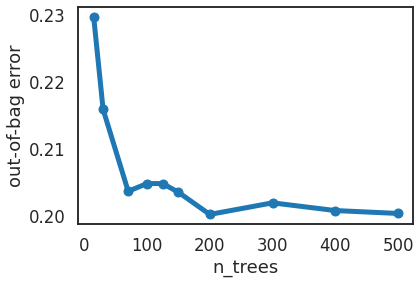

In [15]:
import seaborn as sns
%matplotlib inline

sns.set_context('talk')
sns.set_style('white')
ax=rf_oob_df.plot(legend=False,marker='o',linewidth=5)
ax.set(ylabel='out-of-bag error')

In [17]:
#Random Forest with 200 estimators
RF=RandomForestClassifier(oob_score=True,random_state=42,warm_start=True,n_jobs=-1,n_estimators=200)
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)



from sklearn.metrics import classification_report, accuracy_score,precision_score,recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr=classification_report(y_test,y_pred)
print(cr)

score_df=pd.DataFrame({'accuracy':accuracy_score(y_test,y_pred),
                      'precision':precision_score(y_test,y_pred),
                      'recall':recall_score(y_test,y_pred),
                      'f1':f1_score(y_test,y_pred),
                      'auc':roc_auc_score(y_test,y_pred)},
                     index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       863
           1       0.84      0.77      0.81       876

    accuracy                           0.81      1739
   macro avg       0.82      0.81      0.81      1739
weighted avg       0.82      0.81      0.81      1739

   accuracy  precision    recall       f1       auc
0  0.813111   0.844806  0.770548  0.80597  0.813432


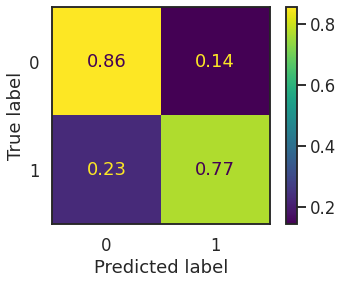

In [19]:
#precision, + values predicted correctly
#recall, actual + values

from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

sns.set_context('talk')
cm=confusion_matrix(y_test,y_pred,normalize='true')
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=RF.classes_)
disp.plot()
plt.show()

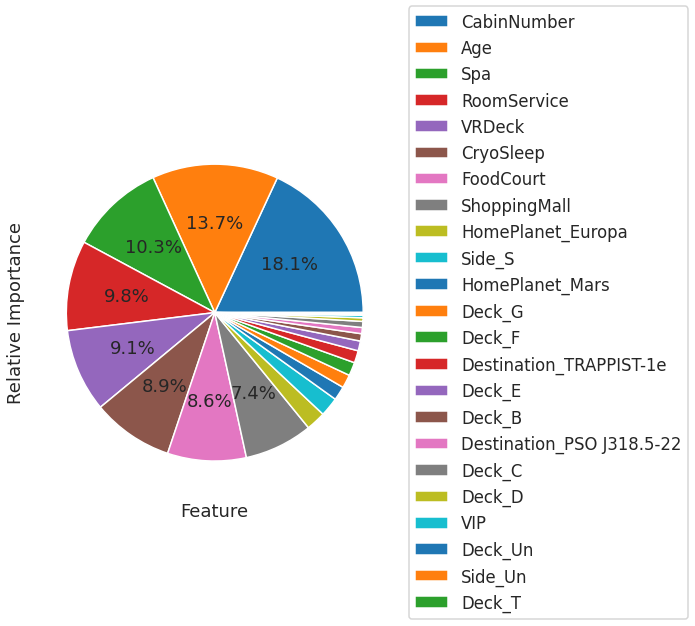

In [20]:
#feature importance
feature_imp=pd.Series(RF.feature_importances_,index=feature_cols).sort_values(ascending=False)
fig,ax=plt.subplots(figsize=(16,6))
ax.pie(feature_imp,labels=None,autopct=lambda pct:'{:1.1f}%'.format(pct) if pct> 5.5 else '')
ax.set(ylabel='Relative Importance')
ax.set(xlabel='Feature')
plt.tight_layout()
plt.legend(loc='center left',bbox_to_anchor=(1,0.5),labels=feature_imp.index)
plt.show()

In [ ]:
#scaling
from sklearn.preprocessing import MinMaxScaler
numeric_variables=['Spa','RoomService','VRDeck','FoodCourt','ShoppingMall']
ordinal_variables=['CabinNumber','Age']
mm=MinMaxScaler()
for column in [ordinal_variables+numeric_variables]:
    training_data[column]=mm.fit_transform(training_data[column])
round(training_data.describe().T,3)

In [ ]:
#split into test and train sets
from sklearn.model_selection import StratifiedShuffleSplit
training_data.value_counts(normalize=True) #prints percentage of values
feature_cols=[x for x in training_data.columns if x != 'Transported']

strat_shuffle_split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
train_idx,test_idx=next(strat_shuffle_split.split(training_data[feature_cols],training_data['Transported']))

#create datasets
x_train = training_data.loc[train_idx,feature_cols]
y_train = training_data.loc[train_idx, 'Transported']
x_test = training_data.loc[test_idx,feature_cols]
y_test = training_data.loc[test_idx, 'Transported']

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
max_k = 50
f1_scores=[]
for k in range(1,max_k+1):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn=knn.fit(x_train,y_train)
    preds=knn.predict(x_test)
    f1=f1_score(preds,y_test)
    f1_scores.append((k,round(f1_score(y_test,preds),4)))
f1_results=pd.DataFrame(f1_scores,columns=['K','F1 Score'])
f1_results.set_index('K')


In [ ]:
ax=f1_results.plot(figsize=(12,12))
ax.set(xlabel='Num of Neighbors',ylabel='F1 Score')
ax.set_xticks(range(1,max_k,2))
plt.ylim((0.7,1))

In [ ]:
#5 is best number for neighbors
knn=KNeighborsClassifier(n_neighbors=5)
knn=knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)

cr=classification_report(y_test,y_pred)
print(cr)

score_df=pd.DataFrame({'accuracy':accuracy_score(y_test,y_pred),
                      'precision':precision_score(y_test,y_pred),
                      'recall':recall_score(y_test,y_pred),
                      'f1':f1_score(y_test,y_pred),
                      'auc':roc_auc_score(y_test,y_pred)},
                     index=pd.Index([0]))
print(score_df)

In [ ]:
sns.set_context('talk')
cm=confusion_matrix(y_test,y_pred,normalize='true')
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
rs=123
l2_model=LogisticRegression(random_state=rs, penalty='l2',multi_class='multinomial',solver='lbfgs',max_iter=1000)
l2_model.fit(x_train,y_train)
y_pred=l2_model.predict(x_test)

In [ ]:
cr=classification_report(y_test,y_pred)
print(cr)

score_df=pd.DataFrame({'accuracy':accuracy_score(y_test,y_pred),
                      'precision':precision_score(y_test,y_pred),
                      'recall':recall_score(y_test,y_pred),
                      'f1':f1_score(y_test,y_pred),
                      'auc':roc_auc_score(y_test,y_pred)},
                     index=pd.Index([0]))
print(score_df)

In [ ]:
l1_model=LogisticRegression(random_state=rs, penalty='l1',multi_class='multinomial',solver='saga',max_iter=1000)
l1_model.fit(x_train,y_train)
y_pred=l1_model.predict(x_test)

In [ ]:
cr=classification_report(y_test,y_pred)
print(cr)

score_df=pd.DataFrame({'accuracy':accuracy_score(y_test,y_pred),
                      'precision':precision_score(y_test,y_pred),
                      'recall':recall_score(y_test,y_pred),
                      'f1':f1_score(y_test,y_pred),
                      'auc':roc_auc_score(y_test,y_pred)},
                     index=pd.Index([0]))
print(score_df)

In [ ]:
#l1 performed better
sns.set_context('talk')
cm=confusion_matrix(y_test,y_pred,normalize='true')
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()